# Data loading: MXNet recordIO

## Overview

This example shows you how to use the data that is stored in the MXNet recordIO format with DALI.

## Creating an Index

To use data that is stored in the recordIO format, we need to use the `readers.MXNet` operator. In addition to the arguments that are common to all readers, such as `random_shuffle`, this operator takes the `path` and `index_path` arguments:

* `path` is the list of paths to recordIO files
* `index_path` is a list (of size 1) that contains the path to the index file. This file, with `.idx` extension, is automatically created when you use MXNet's `im2rec.py` utility; and can also be obtained from the recordIO file by using the `rec2idx` utility that is included with DALI.

The `DALI_EXTRA_PATH` environment variable should point to the location where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded.

**Important**: Ensure that you check out the correct release tag that corresponds to the installed version of DALI.

In [1]:
import os
from pathlib import Path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import nvidia.dali.experimental.dynamic as ndd

dali_extra_dir = Path(os.environ["DALI_EXTRA_PATH"])
base = dali_extra_dir / "db" / "recordio"
batch_size = 16

idx_files = [base / "train.idx"]
rec_files = [base / "train.rec"]

## Reading and Processing Images

1. Read the images stored in the recordIO format, decode them and prepare them for ingestion in a DL framework.

   Processing images involves cropping, normalizing, and `HWC` -> `CHW` conversion process.

In [2]:
reader = ndd.readers.MXNet(path=rec_files, index_path=idx_files)

for jpegs, labels in reader.next_epoch(batch_size=batch_size):
    images = ndd.decoders.image(jpegs, device="gpu")
    output = ndd.crop_mirror_normalize(
        images,
        dtype=ndd.float32,
        crop=(224, 224),
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
    )
    break  # Run once

2. To visualize the results, use the `matplotlib` library, which expects images in `HWC` format, but the output is in `CHW`.

   **Note**: `CHW` is the preferred format for most Deep Learning frameworks.
   
3. For the visualization purposes, transpose the images back to the `HWC` layout.

In [3]:
def show_images(image_batch: ndd.Batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(20, (20 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j, img in enumerate(image_batch):
        plt.subplot(gs[j])
        plt.axis("off")
        img_chw = np.asarray(img.cpu())
        img_hwc = np.transpose(img_chw, (1, 2, 0)) / 255.0
        plt.imshow(img_hwc)
    plt.show()

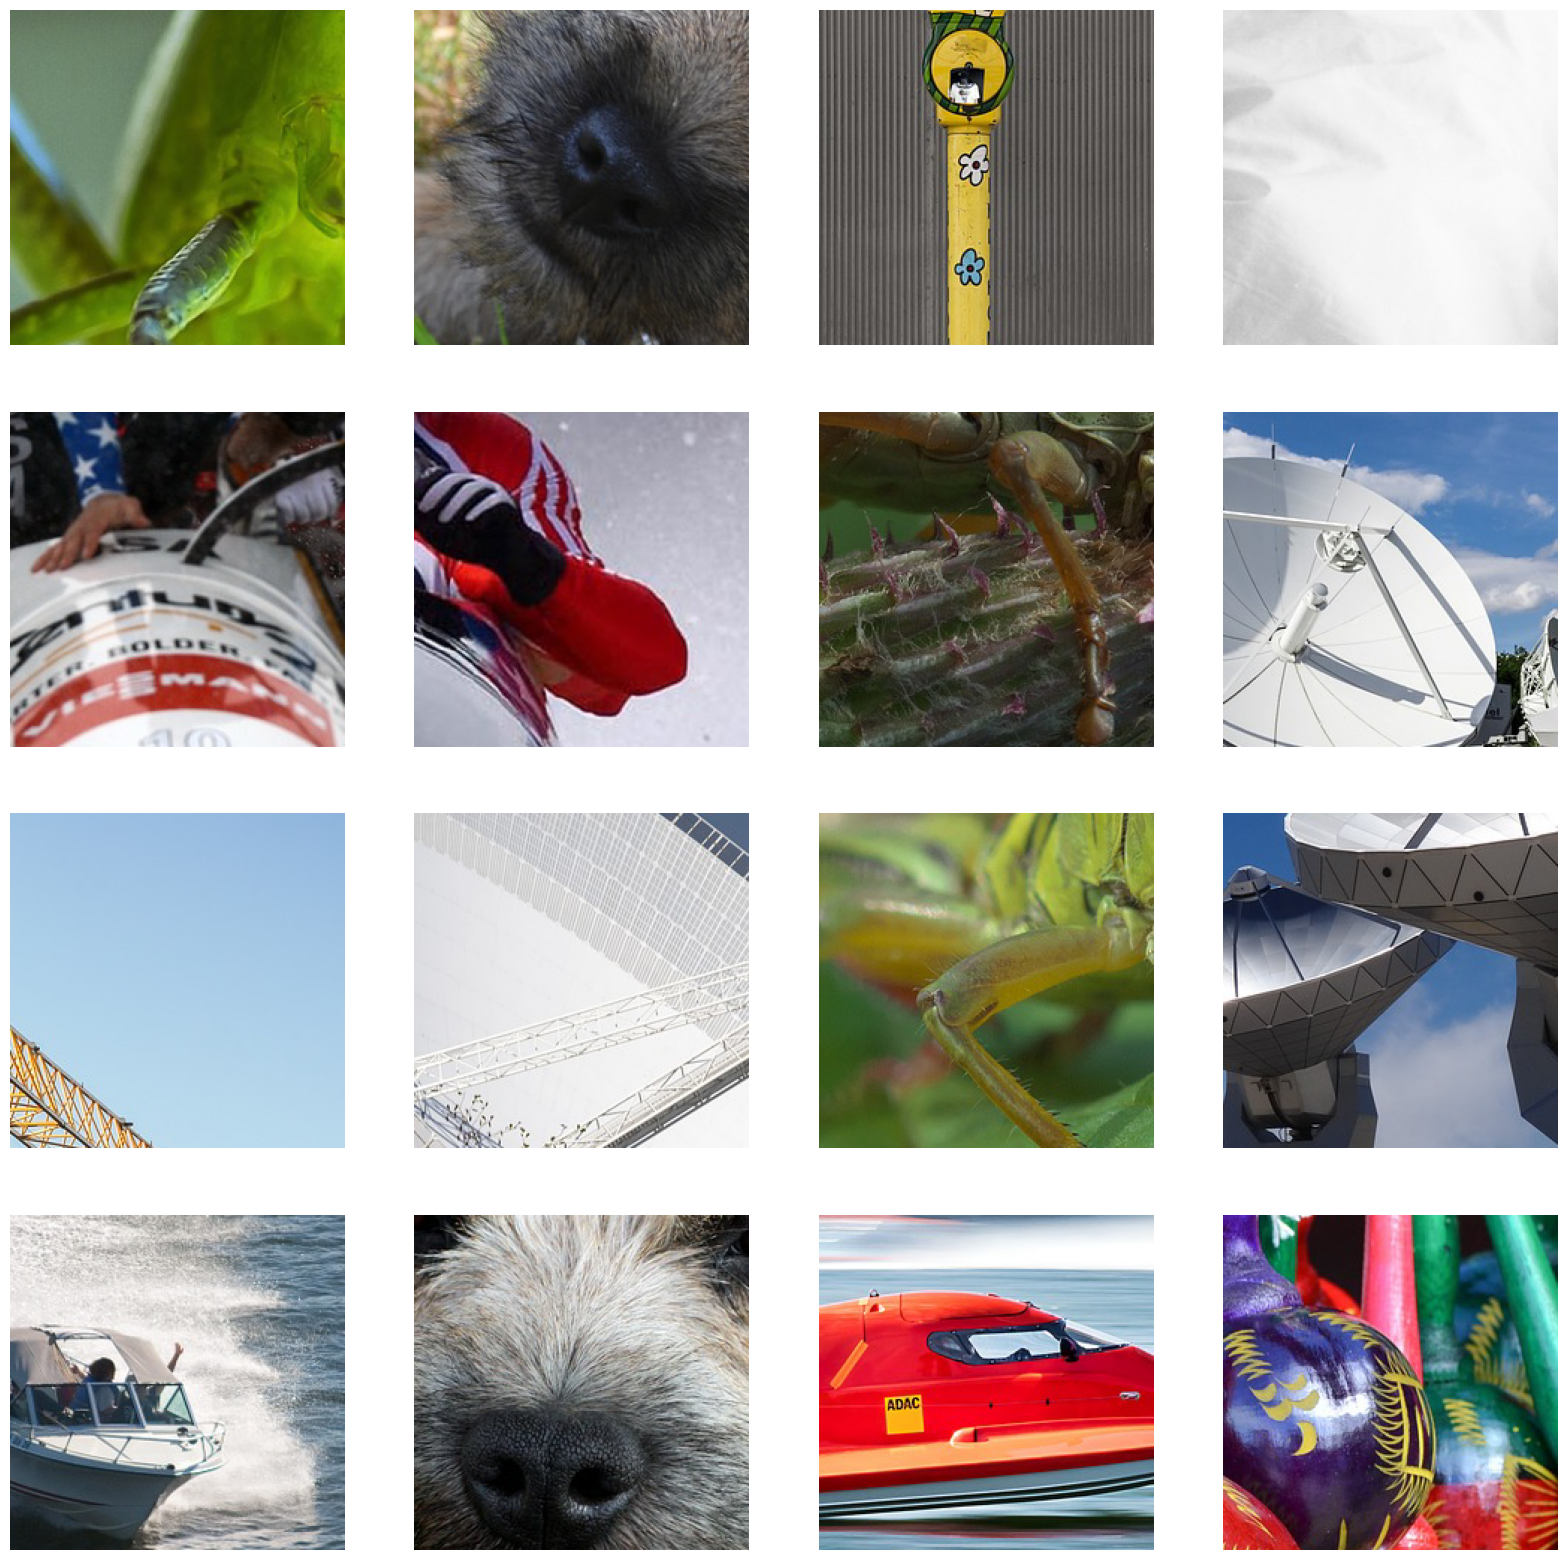

In [4]:
show_images(output)